### Predict the masses of the brains using the data, and later compare it with the actual masses of brains mentioned in the dataset.

In [1]:
#importing initial libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#creating dataframe
file = 'brain_wght.csv'
df = pd.read_csv(file)
print("dataframe info \n")
print(df.info())
print("dataframe head \n")
print(df.head())

dataframe info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Gender               237 non-null    int64
 1   Age Range            237 non-null    int64
 2   Head Size(cm^3)      237 non-null    int64
 3   Brain Weight(grams)  237 non-null    int64
dtypes: int64(4)
memory usage: 7.5 KB
None
dataframe head 

   Gender  Age Range  Head Size(cm^3)  Brain Weight(grams)
0       1          1             4512                 1530
1       1          1             3738                 1297
2       1          1             4261                 1335
3       1          1             3777                 1282
4       1          1             4177                 1590


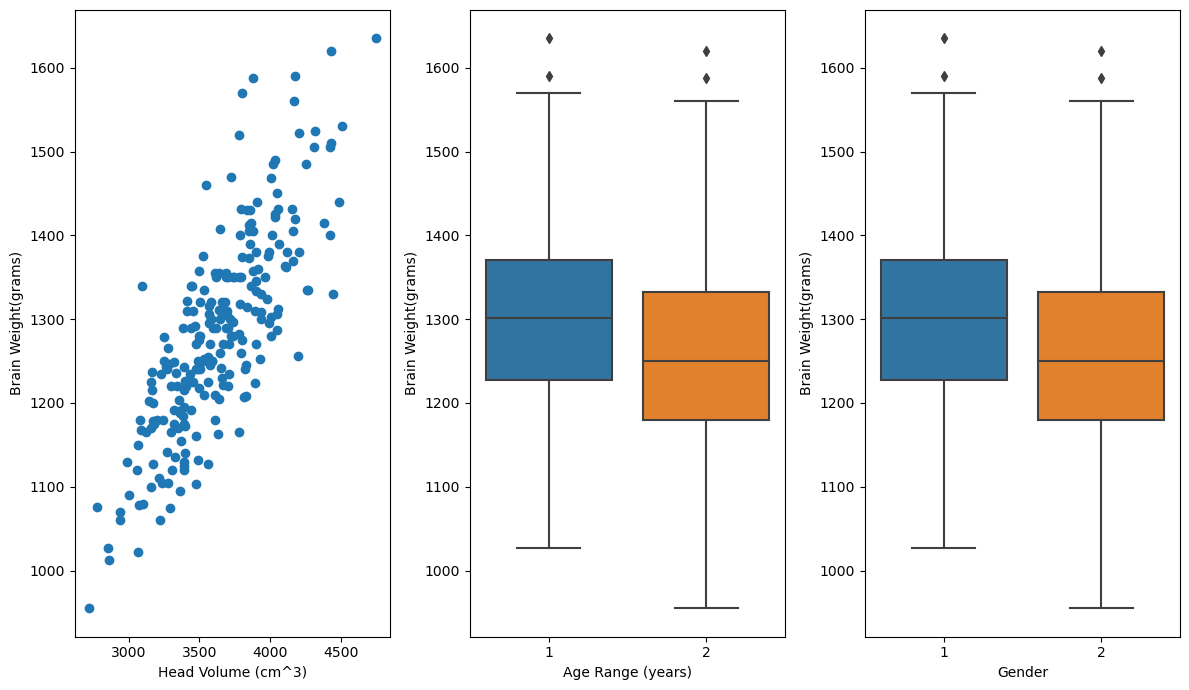

In [3]:
#plotting data
fig, ax = plt.subplots(1, 3, figsize=(12,7))
ax[0].scatter(df['Head Size(cm^3)'], df['Brain Weight(grams)'])
ax[0].set_xlabel("Head Volume (cm^3)")
ax[0].set_ylabel("Brain Weight(grams)")
sns.boxplot(data=df, x='Age Range', y='Brain Weight(grams)', ax=ax[1])
ax[1].set_xlabel("Age Range (years)")
sns.boxplot(data=df, x='Age Range', y='Brain Weight(grams)', ax=ax[2])
ax[2].set_xlabel("Gender")
fig.tight_layout()
plt.show()

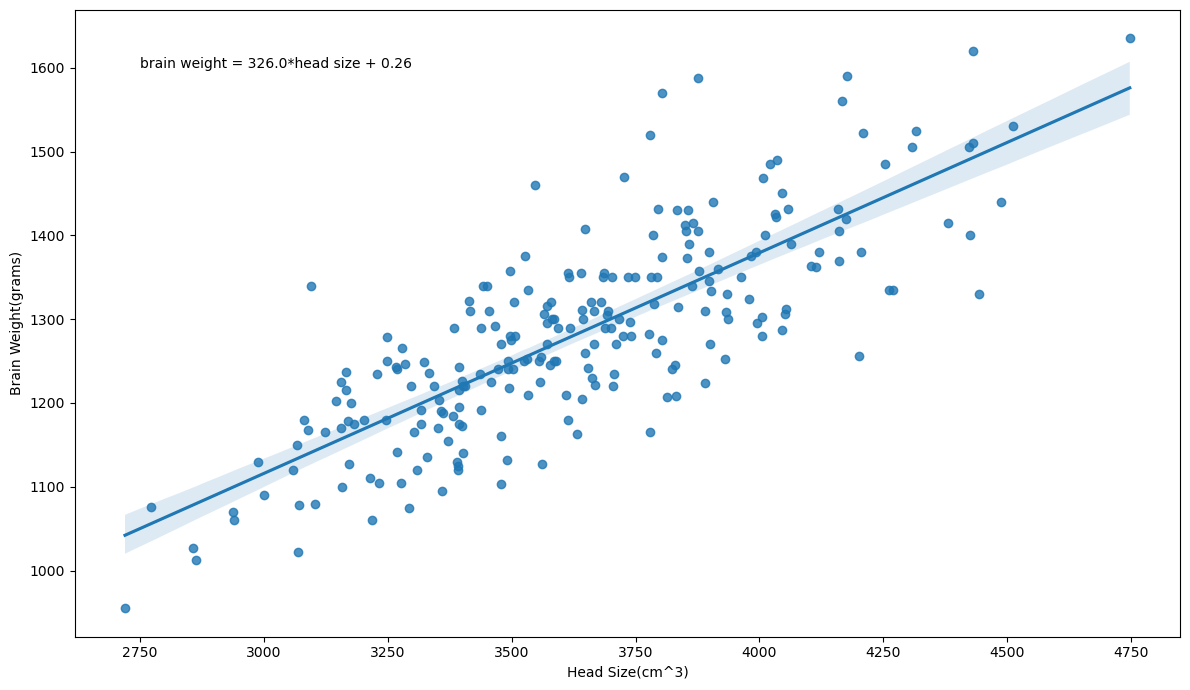

In [4]:
#closer look at head size/volume 

y = df['Brain Weight(grams)']
X = df['Head Size(cm^3)']
X = sm.add_constant(X)
simple_regression = sm.OLS(y, X).fit()

model_equation = 'brain weight = {}*head size + {}'.format(round(simple_regression.params[0],0), 
                                                           round(simple_regression.params[1],2))
#rsq = 'Rsq = {}'.format(simple_regression.r_squared)
fig_lin = plt.figure(figsize=(12, 7))
sns.regplot(data=df, x='Head Size(cm^3)', y='Brain Weight(grams)')
plt.text(x=2750, y=1600, s=model_equation)
#plt.text(x=2750, y=1550, s=rsq)
plt.tight_layout()
plt.show()



In [5]:
print(simple_regression.summary())

                             OLS Regression Results                            
Dep. Variable:     Brain Weight(grams)   R-squared:                       0.639
Model:                             OLS   Adj. R-squared:                  0.638
Method:                  Least Squares   F-statistic:                     416.5
Date:                 Sun, 04 Aug 2024   Prob (F-statistic):           5.96e-54
Time:                         20:57:12   Log-Likelihood:                -1350.3
No. Observations:                  237   AIC:                             2705.
Df Residuals:                      235   BIC:                             2711.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             325.5734     4

When performing a univariate analysis using only head size as a predictor for brain weight, we get that 63% of the variability is accounted for using this model. 

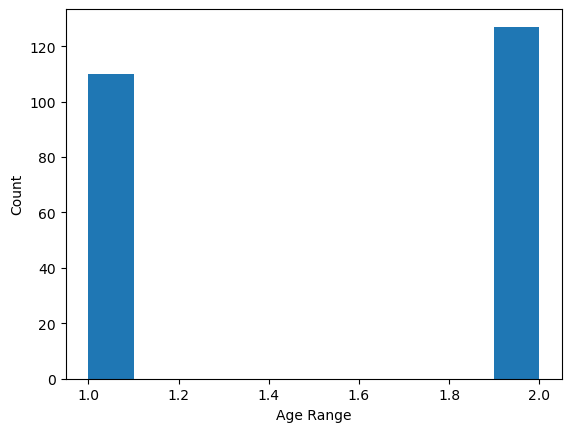

In [6]:
#looking at what age range is
fig, ax = plt.subplots()
ax.hist(df['Age Range'])
ax.set_xlabel("Age Range")
ax.set_ylabel("Count")
plt.show()

Seems to be some binary data like gender.  Diving into the data file, 1 is age group > 18, 2 is age group <18.

For this task, a supervised regression model but will try several (Linear, Lasso, Ridge). These models will use all features in an attempt to reduce the mean square error (or increase the Rsq) of the model.

In [7]:
#importing libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [8]:
ridge = Ridge(max_iter=20000)
lasso = Lasso()
linear_regression = LinearRegression()

models = [ridge, lasso]

In [9]:
#creating ind. var array and target array and splitting
X = df.drop("Brain Weight(grams)", axis=1).values
y = df["Brain Weight(grams)"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ridge Regression

In [10]:
#creating kfold and executing gridsearch to find best parameters for Ridge
kf = KFold(n_splits=4, shuffle=True, random_state=42)
param_grid = {'alpha':np.arange(0, 5, 10), "solver": ['sag', 'lsqr']}
ridge_cv = GridSearchCV(ridge, param_grid, cv=kf)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_, ridge_cv.best_score_)

{'alpha': 0, 'solver': 'sag'} 0.6082008164114288


R^2 isn't good, but may have room for improvement, will try linear regression and polynomial features

## Linear regression

In [11]:
#trying linear regression
linear_regression.fit(X_train, y_train)
print(linear_regression.score(X_train, y_train))

0.6264565800251868


Doesn't seem to perform much better

## Lasso

In [12]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
lasso_param_grid = {'alpha':np.arange(0.1, 5, 10)}
lasso_cv = GridSearchCV(lasso, lasso_param_grid, cv=kf)
lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_, lasso_cv.best_score_)

{'alpha': 0.1} 0.6023421805714002


It seems setting alpha to 0 for both a lasso and ridge regression is the appropriate hyperparameter value. This means, essentially, that the ordinary least squares. This is proven when we compare mean square errors.

In [13]:
#tyring linear regression with polynomial features
poly_regression = LinearRegression()
polyfeature = PolynomialFeatures(degree=2, include_bias=False)
X_poly = polyfeature.fit_transform(X_train)
print(X_poly[0])
poly_regression.fit(X_poly, y_train)
print(poly_regression.score(X_poly, y_train))

[2.0000000e+00 1.0000000e+00 3.1810000e+03 4.0000000e+00 2.0000000e+00
 6.3620000e+03 1.0000000e+00 3.1810000e+03 1.0118761e+07]
0.6339549260385793


slight improvement when increasing polynomial degree, trying for loop to loop through degrees

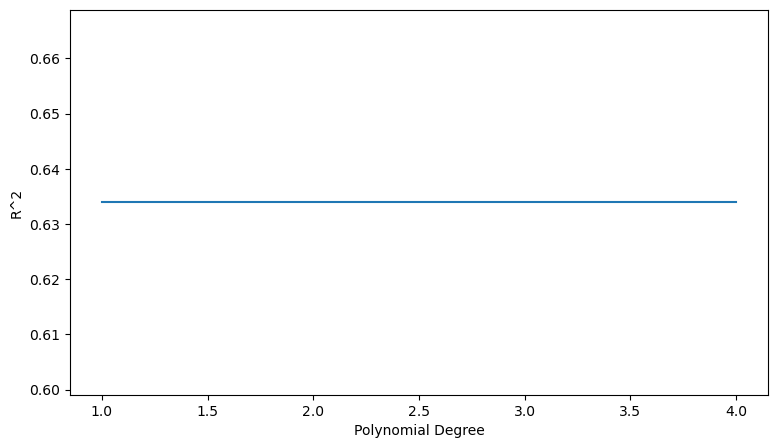

In [14]:
scores = []

for i in range(1, 5):
    poly_feature = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = polyfeature.fit_transform(X_train)
    poly_regression.fit(X_poly, y_train)
    scores.append(poly_regression.score(X_poly, y_train))
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range(1,5), scores)
ax.set_xlabel("Polynomial Degree")
ax.set_ylabel("R^2")
plt.show()

increasing polynomial features of X_train didn't improve the model.

In [15]:
#making predictions
y_pred = linear_regression.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))

65.95452567714389


model has an error of 66 grams, which is < 7% of minimum.

In [16]:
#printing model coefficients and intercept
equation = 'brain weight = {}*Gender  {}*Age Range + {}*head size + {}'.format(round(linear_regression.coef_[0],2),
                                                                   round(linear_regression.coef_[1],2),
                                                                   round(linear_regression.coef_[2],2),
                                                                   round(linear_regression.intercept_,2))
print(equation)

brain weight = -14.45*Gender  -23.65*Age Range + 0.25*head size + 436.45


# Discussion

It seems as though the age is an indicator of a smaller brain weight. The strongest influencer seems to be gender.  Individuals labeled as gender 2 have smaller brains than those labeled gender 1.  Interestingly, the volume of your head played less of an influence as the others, the bigger the volume did not mean the more brain weight as much as one would suspect.

The models attempted for use in this analysis were ridge, lasso, ordinary least squares, and polynomial. The hyperparameter tuning exercise of both ridge and lass pointed towards ordinary least squares (OLS) as being the more appropriate of the 3 models. However, improvement in mean square error was not signficant.  The polynomial model also did not provide better performance. Therefore, OLS was used on the test set to make predictions and yield a final model equation.  It's important to note, the chosen model explains approximately 62% of the variability. It is likely additionaly features are required for better fitting.